In [2]:
import warnings
warnings.simplefilter("ignore")

import tensorflow as tf
import pandas as pd
import numpy as np
import time
from matplotlib import pyplot as plt

import xgboost
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss

%matplotlib inline

In [5]:
def run_cross_val(X, y, n_fold=5, random_state=1):    
    kf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=random_state)
    result_df = pd.DataFrame()
    fold_num = 0
    
    for train, test in kf.split(X, y):    
        fold_num += 1
        print(fold_num)
        x_train = X[train]
        y_train = y[train]
        x_test = X[test]
        y_test = y[test]
        
        classifiers = {"LR": LogisticRegression(), "XGB": xgboost.XGBClassifier()}
        for classifier_name, clf in classifiers.items():
            t0 = time.time()
            clf.fit(x_train, y_train)
            prediction = clf.predict(x_test)
            if fold_num == 5:
                print("{0} takes {1:.5f} seconds per fold".format(
                    classifier_name, time.time()-t0))
            accuracy = accuracy_score(prediction, y_test)
            result_df.loc[fold_num, classifier_name] = accuracy
    return result_df


def prep_data(X_df, y_df, label):
    joined_df = X_df.join(y_df).dropna() # remove rows without this label
    X = joined_df[X_df.columns].as_matrix()
    y_raw = joined_df[label]
    le = LabelEncoder()
    y = le.fit_transform(y_raw)
    return X, y, le


def sample_data(X, y, frac=0.01):
    idx = range(int(X.shape[0])) 
    sample_idx = np.random.choice(idx, size=int(len(idx)*frac))
    return X[sample_idx], y[sample_idx]

### Predictions

In [8]:
t0 = time.time()
mean_df = pd.DataFrame()
error_df = pd.DataFrame()

for label in ["tissue", "gender", "tumor"]:
    print(label)
    for variance in [0.2, 0.6, 0.7, 0.8, 0.9]:
        print("PCA variance", variance)
        X_df = pd.read_csv("./data/mRNA_PCA_{0}_variance_MinMaxScaled.csv".format(variance), index_col="sample_id")
        y_df = pd.read_csv("./data/labels.csv", index_col="sample_id")
        X, y, _ = prep_data(X_df, y_df, "label_"+label)
#         X_sample, y_sample = sample_data(X, y, frac=0.01)
        result_df = run_cross_val(X, y, n_fold=5, random_state=0)
        data_row = result_df.mean().to_dict()
        data_row.update({"label":label, "PCA_variance":variance})
        error_row = result_df.std().to_dict()
        error_row.update({"label":label, "PCA_variance":variance})
        mean_df = mean_df.append(data_row, ignore_index=True)
        error_df = error_df.append(error_row, ignore_index=True)
        
mean_df = mean_df.set_index(["label", "PCA_variance"]).unstack()
error_df = error_df.set_index(["label", "PCA_variance"]).unstack()
print("this whole thing takes {0:.2} seconds to run".format(time.time()-t0))

tissue
PCA variance 0.2
1
2
3
4
5
LR takes 0.20517 seconds per fold
XGB takes 2.75764 seconds per fold
PCA variance 0.6
1
2
3
4
5
LR takes 1.02062 seconds per fold
XGB takes 4.03034 seconds per fold
PCA variance 0.7
1
2
3
4
5
LR takes 2.70470 seconds per fold
XGB takes 6.69282 seconds per fold
PCA variance 0.8
1
2
3
4
5
LR takes 9.99486 seconds per fold
XGB takes 19.18494 seconds per fold
PCA variance 0.9
1
2
3
4
5
LR takes 55.90909 seconds per fold
XGB takes 93.07880 seconds per fold
gender
PCA variance 0.2
1
2
3
4
5
LR takes 0.00483 seconds per fold
XGB takes 0.09433 seconds per fold
PCA variance 0.6
1
2
3
4
5
LR takes 0.03413 seconds per fold
XGB takes 0.27306 seconds per fold
PCA variance 0.7
1
2
3
4
5
LR takes 0.12363 seconds per fold
XGB takes 0.38764 seconds per fold
PCA variance 0.8
1
2
3
4
5
LR takes 0.30748 seconds per fold
XGB takes 0.77734 seconds per fold
PCA variance 0.9
1
2
3
4
5
LR takes 1.24658 seconds per fold
XGB takes 3.48841 seconds per fold
tumor
PCA variance 0.2


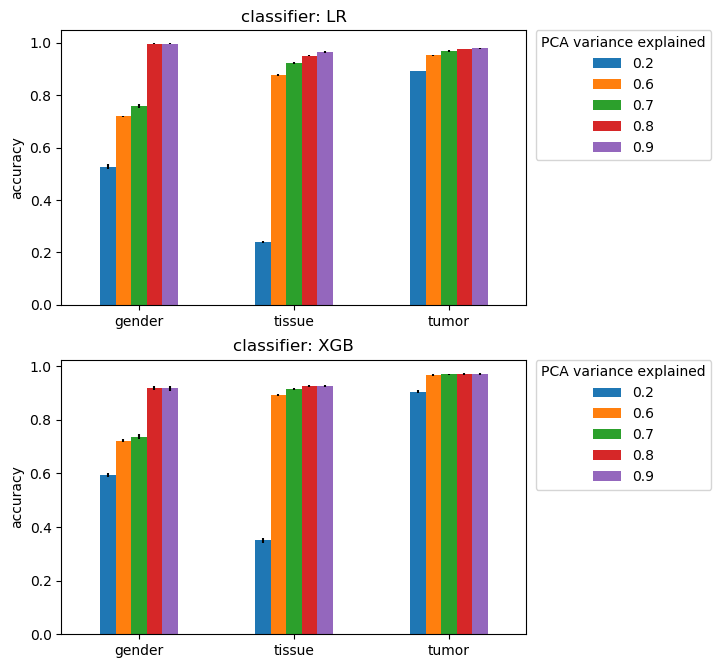

In [9]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(6, 8), dpi=100)
for i, clf_name in enumerate(["LR", "XGB"]):
    mean_df[clf_name].plot.bar(yerr=error_df[clf_name], rot=0, ax=axes[i])
    axes[i].legend(title="PCA variance explained", 
                   bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
    axes[i].set_title("classifier: {0}".format(clf_name))
    axes[i].set_ylabel("accuracy")
    axes[i].set_xlabel("")

In [10]:
mean_df

LR                                               XGB  \
PCA_variance       0.2       0.6       0.7       0.8       0.9       0.2   
label                                                                      
gender        0.526715  0.719050  0.758200  0.995025  0.995855  0.595153   
tissue        0.239786  0.876281  0.922794  0.950896  0.964340  0.350248   
tumor         0.891949  0.951455  0.969049  0.976511  0.978169  0.904754   

                                                      
PCA_variance       0.6       0.7       0.8       0.9  
label                                                 
gender        0.722182  0.736922  0.917095  0.917555  
tissue        0.891763  0.915614  0.927236  0.926302  
tumor         0.966930  0.968681  0.971537  0.970524

### Two component PCA prediction baseline

In [6]:
X_df = pd.read_csv("./data/mRNA_PCA_0.2_variance_MinMaxScaled.csv", index_col="sample_id")
y_df = pd.read_csv("./data/labels.csv", index_col="sample_id")
X, y, _ = prep_data(X_df, y_df, "label_tissue"+label)
result_df = run_cross_val(X, y, n_fold=5, random_state=0)

NameError: name 'label' is not defined